In [14]:
#remove stupid warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import datetime
import numpy as np
import sys
import collections
import itertools
import matplotlib.pyplot as plt
import random
import math
import geopandas
import contextily as cx
from shapely.geometry import Point
import copy
%matplotlib inline

In [2]:
filepath = r'C:\Users\n10405992\OneDrive - Queensland University of Technology\Raghav Malhotra - RM\Papers\RCS\RCS Codes\Path Choice\Data\network_attributes_updated.csv'
network = pd.read_csv(filepath, usecols = ['From_o_sen', 'To_d_senso', 'Total_Kilo', 'speed'])
# network['Total_Kilo'] = round(network['Total_Minu']*1000,2)
network['fft'] = network['Total_Kilo']/network['speed']
dist_m = network.groupby('From_o_sen')[['To_d_senso', 'Total_Kilo']].apply(lambda x: x.set_index('To_d_senso').to_dict(orient='index')).to_dict()
for key in dist_m:
    for x in dist_m[key]:
        for y in dist_m[key][x]:
            dist_m[key][x] = dist_m[key][x][y]

In [3]:
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))

    q, seen, mins = [(0,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = cost + c
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return float("inf")

In [4]:
def linearize(value, agg=None):
    if agg is None:
        agg = []
    if isinstance(value, (tuple, list)):
        for item in value:
            linearize(item, agg)
    else:
        agg.insert(0,value)
    return agg[:-1]

In [5]:
def unnest(d, keys=[]):
    result = []
    for k, v in d.items():
        if isinstance(v, dict):
            result.extend(unnest(v, keys + [k]))
        else:
            result.append(tuple(keys + [k, v]))
    return result

In [6]:
def get_path_length(orig, dest):
    path = linearize(dijkstra(unnest(dist_m), orig, dest))
    leng = 0
    for index in range(len(path)-1):
        leng += dist_m[path[index]][path[index+1]]
    return leng

In [7]:
def generate_geo_path(path, shpfile):
    geopath = []
    for node_index in range(len(path)-1):
        try:
            link = shpfile[(shpfile.From_origi == path[node_index]) & (shpfile.To_destina == path[node_index+1])]['RouteName'].values[0]
        except:
            print(path[node_index], path[node_index+1])
        geopath.append(link)
    return geopath

## Generate Mn

In [12]:
def yensKSp(graph, source, target, k = 1):
    A = [] #Shortest Path
    counter = 0
    graphy = copy.deepcopy(graph)
    tuple_graph = unnest(graphy)
    counter+=1
    A.append(linearize(dijkstra(tuple_graph, source, target)))
    B = [] #K-th Shortest paths will be stored here
    if source == target:
        return "Source and Target are the same"
    
    if not(A[0]):
        return "Target is not reachable from the Source"
    
    for i in range(1,k):
        for j in range(int(len(A[i-1]) - 1)):
            spurNode = A[i-1][j]
            rootpath = A[i-1][0:j+1]  
            graphy = copy.deepcopy(graph)
            for x in A:
                if rootpath == x[0:j+1]:
                    dict_remove = graphy[rootpath[j]]
                    try:
                        dict_remove.pop(x[j+1])
                    except:
                        continue
            if (len(rootpath) > 1):
                for y in rootpath[0:-1]:
                    graphy.pop(y)
                    keys = list(graphy.keys())
                    for c in range(len(graphy)):
                        x = graphy[keys[c]]
                        if y in x:
                            x.pop(y)
            tuple_graph = unnest(graphy)
            counter+=1
            spurPath = linearize(dijkstra(tuple_graph, spurNode, target))
            if spurPath:
                totalPath =  rootpath + spurPath[1:]
            else:
                continue
            if totalPath not in B:
                B.append(totalPath)
        if B == []:
            print("No further paths available")
            break
        for path in B:
            if path not in A:
                A.append(path)
        if len(A) >= k:
            return A[:k]
        graphy = copy.deepcopy(graph)
        counter+=1
    return A[:k]
                    

In [71]:
origin = 10599
destination = 10651
paths = yensKSp(dist_m, origin, destination, 20)

In [72]:
new_dist_m = {}
for path in paths:
    for link_index in range(len(path)-1):
        if path[link_index] in new_dist_m.keys():
            pass
        else:
            new_dist_m[path[link_index]] = {}
            new_dist_m[path[link_index]][path[link_index+1]] = dist_m[path[link_index]][path[link_index+1]]
            
            

In [73]:
new_dist_m

{10599: {10572: 1.73985741},
 10572: {10422: 0.8315066},
 10422: {10489: 0.14593894},
 10489: {10421: 1.2149902},
 10421: {10949: 0.20766966},
 10949: {10459: 0.25970019},
 10459: {10773: 0.59453293},
 10773: {10478: 0.8457645},
 10478: {10652: 0.16661634},
 10652: {10653: 0.25337757},
 10653: {10651: 0.18540187},
 10633: {10598: 0.80051231},
 10598: {10470: 2.39569941},
 10470: {10459: 1.52651041},
 10589: {10736: 0.41517194},
 10736: {10612: 0.98031095},
 10612: {10611: 1.19849158},
 10611: {10426: 0.23140768},
 10426: {10630: 0.27492911},
 10630: {10486: 0.2130034},
 10486: {999123: 0.03426466},
 999123: {10626: 0.37798448},
 10626: {10476: 0.0566354},
 10476: {10625: 0.07550018},
 10625: {10497: 0.20622076},
 10497: {10425: 0.19257539},
 10425: {10450: 0.33793455},
 10450: {10478: 0.34606157},
 10657: {10611: 0.81812271},
 10681: {10684: 0.18060931},
 10684: {10689: 0.43785508},
 10689: {10688: 0.07043037},
 10688: {10632: 0.18344467},
 10632: {10653: 0.30754313},
 999154: {999155:


## Specify shortest path

In [74]:
shortest_p = linearize(dijkstra(unnest(new_dist_m), origin, destination))

In [99]:
node = origin
path = []
while node != destination:
    x_l = {key: None for key in dist_m[node].keys()}
    w_l = {key: None for key in dist_m[node].keys()}
    prb = {key: None for key in dist_m[node].keys()}
    for candidate in x_l.keys():
        sp_len_v = get_path_length(origin, destination)
        sp_len_s0 = get_path_length(origin, node)
        link_len = get_path_length(node, candidate)
        sp_len_sd = get_path_length(candidate, destination)
        x_l[candidate] = sp_len_v/(sp_len_s0 + link_len + sp_len_sd)
        w_l[candidate] = 1-(1-x_l[candidate]**5)
    for candidate in x_l.keys():
        prb[candidate] = w_l[candidate]/sum(w_l.values())
    draw = np.random.random()
    cumulative_prob = 0
    candidates = list(prb.keys())
    probabilities = list(prb.values())
    for option, probability in zip(candidates, probabilities):
        cumulative_prob += probability
        # Check if the random number falls within the cumulative probability range
        if draw <= cumulative_prob:
            node = option
            break
    path.append(node)

## Geopandas

In [100]:
shapefile = geopandas.read_file("BMS_network.shp")
geopath = generate_geo_path(path, shapefile)

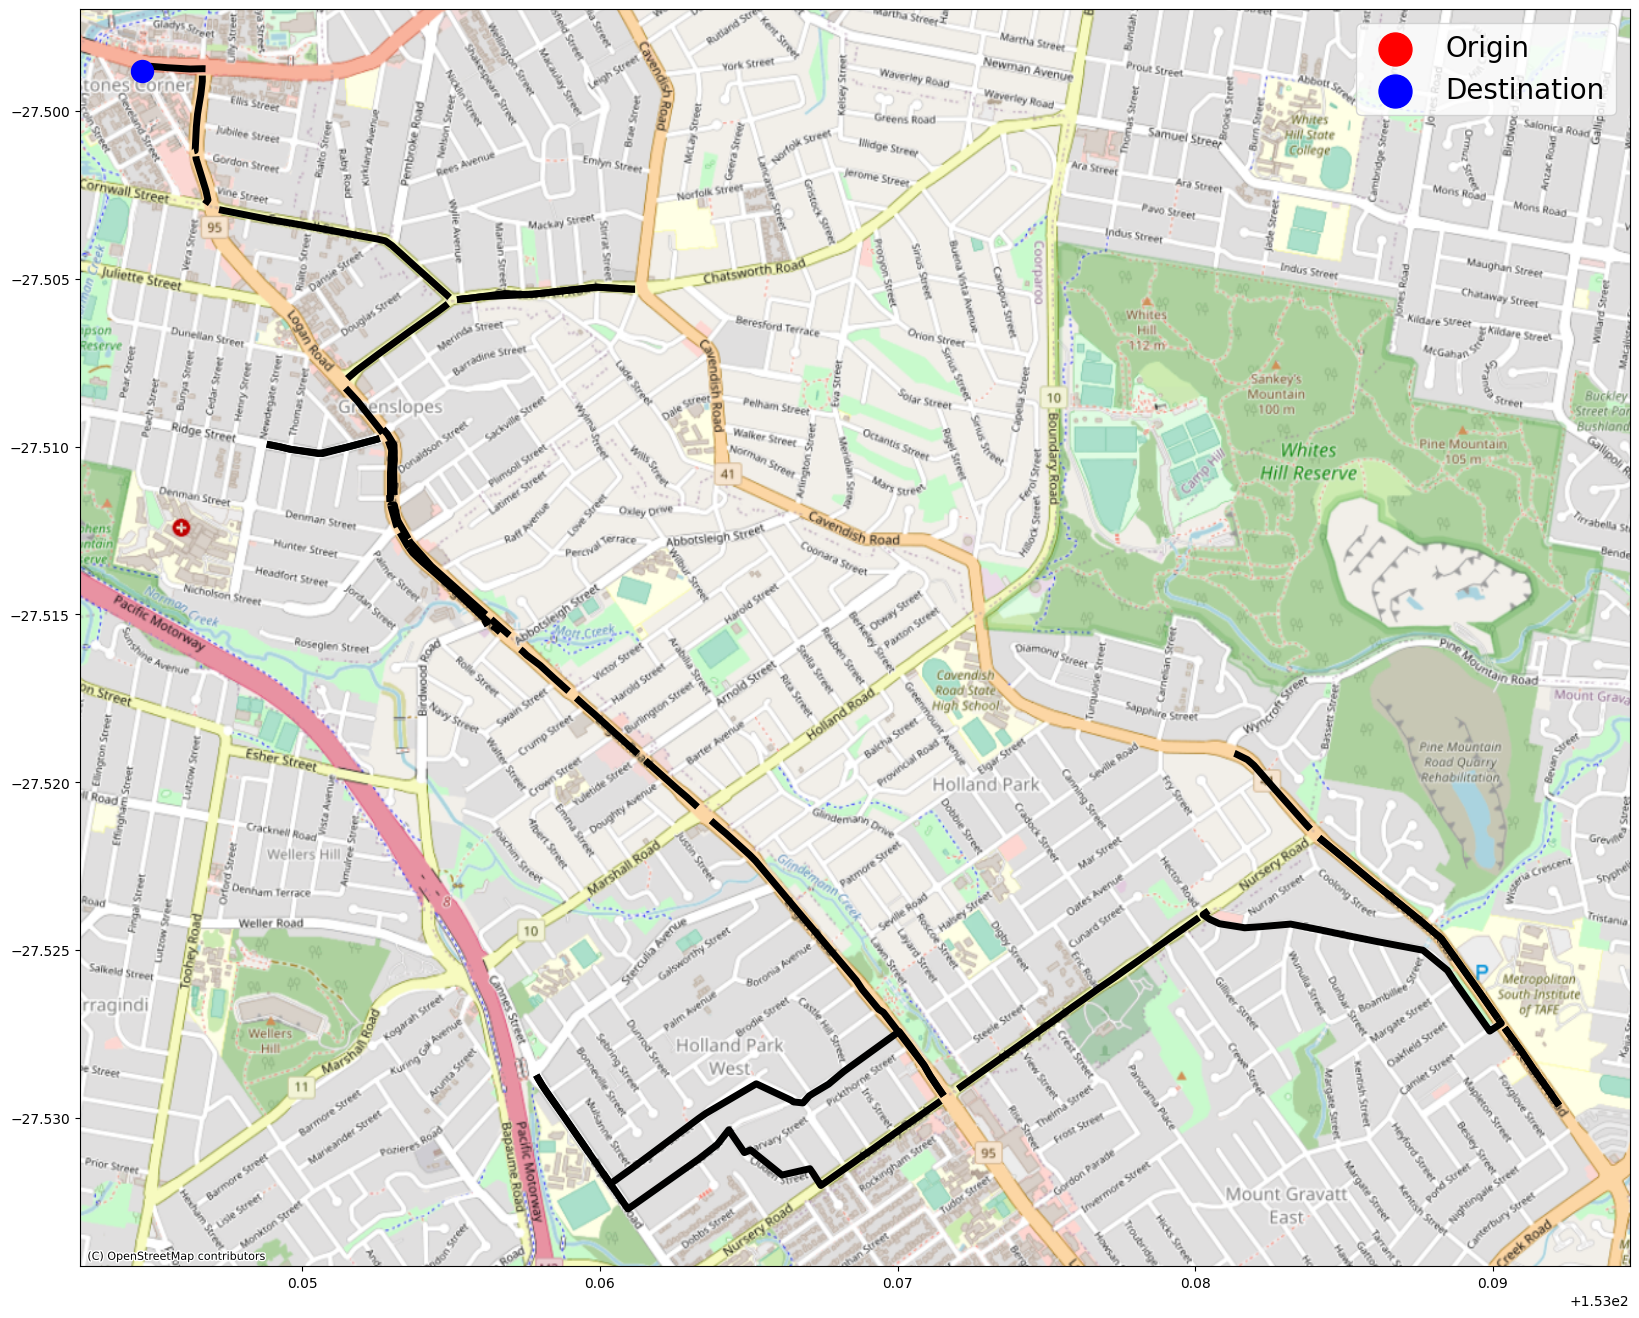

In [101]:
fig, ax = plt.subplots(figsize = (20,20))
m2 = shapefile[shapefile.RouteName.isin(geopath)]
m2.plot(ax = ax, color = 'black', linewidth = 5)
origin_pt = Point(tuple(shapefile[shapefile.From_origi == origin][['From_x', 'From_y']].values[0]))
destination_pt = Point(tuple(shapefile[shapefile.From_origi == destination][['From_x', 'From_y']].values[0]))
cx.add_basemap(ax = ax, crs = shapefile.crs, source = cx.providers.OpenStreetMap.Mapnik)
origin_plot = geopandas.GeoSeries([origin_pt], crs={'init': 'epsg:4326'}).plot(ax = ax, color = "red", markersize = 250, zorder = 10, label = "Origin")
destination_plot = geopandas.GeoSeries([destination_pt], crs={'init': 'epsg:4326'}).plot(ax = ax, color = "blue", markersize = 250, zorder = 10, label = "Destination")
ax.legend(markerscale = 1.5, fontsize = 20)